## Independent Analysis 2 - Srinivas (handle: thewickedaxe)
** PLEASE SCROLL TO THE BOTTOM OF THE NOTEBOOK TO FIND THE QUESTIONS AND THEIR ANSWERS**

### Initial Data Cleaning

In [174]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import manifold, datasets
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.cross_validation import LeavePOut


# Let's read the data in and clean it

def get_NaNs(df):
    columns = list(df.columns.get_values()) 
    row_metrics = df.isnull().sum(axis=1)
    rows_with_na = []
    for i, x in enumerate(row_metrics):
        if x > 0: rows_with_na.append(i)
    return rows_with_na

def remove_NaNs(df):
    rows_with_na = get_NaNs(df)
    cleansed_df = df.drop(df.index[rows_with_na], inplace=False)     
    return cleansed_df

initial_data = pd.DataFrame.from_csv('Data_Adults_1_reduced.csv')
cleansed_df = remove_NaNs(initial_data)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = cleansed_df.select_dtypes(include=numerics)
print X.shape

(3926, 328)


The change from last week was that we also threw out 

In [175]:
# Let's now clean columns getting rid of certain columns that might not be important to our analysis

cols2drop = ['GROUP_ID', 'doa', 'Baseline_header_id', 'Concentration_header_id',
             'Baseline_Reading_id', 'Concentration_Reading_id']
X = X.drop(cols2drop, axis=1, inplace=False)
print X.shape

# For our studies children skew the data, it would be cleaner to just analyse adults
X = X.loc[X['Age'] >= 18]

print X.shape

(3926, 322)
(3881, 322)


we've now dropped the last of the discrete numerical inexplicable data, and removed children from the mix

### Extracting the samples we are interested in

In [176]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD = X.loc[X['ADHD'] == 1]
ADHD = ADHD.loc[ADHD['Bipolar'] == 0]

BP = X.loc[X['Bipolar'] == 1]
BP = BP.loc[BP['ADHD'] == 0]

print ADHD.shape
print BP.shape

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD_df = ADHD.copy(deep = True)
BP_df = BP.copy(deep = True)
ADHD = pd.DataFrame(ADHD.drop(['Patient_ID'], axis = 1, inplace = False))
BP = pd.DataFrame(BP.drop(['Patient_ID'], axis = 1, inplace = False))

(1383, 322)
(440, 322)


we see here that there 1383 people who have ADHD but are not Bipolar and 440 people who are Bipolar but do not have ADHD

### Dimensionality reduction

#### PCA

In [177]:
combined = pd.concat([ADHD, BP])
combined_backup = pd.concat([ADHD, BP])


pca = PCA(n_components = 24, whiten = "True").fit(combined)
combined = pca.transform(combined)
print sum(pca.explained_variance_ratio_)

combined = pd.DataFrame(combined)

ADHD_reduced_df = combined[:1383]
BP_reduced_df = combined[1383:]

ADHD_reduced_df_id = ADHD_reduced_df.copy(deep = True)
BP_reduced_df_id = BP_reduced_df.copy(deep = True)

ADHD_reduced_df_id['Patient_ID'] = 123
BP_reduced_df_id['Patient_ID'] = 123

print ADHD_reduced_df.shape
print BP_reduced_df.shape

print ADHD_reduced_df_id.shape
print BP_reduced_df_id.shape

# resorting to some hacky crap, that I am ashamed to write, but pandas is refusing to cooperate
z = []
for x in BP_df['Patient_ID']:
    z.append(x)
BP_reduced_df_id['Patient_ID'] = z

z = []
for x in ADHD_df['Patient_ID']:
    z.append(x)
ADHD_reduced_df_id['Patient_ID'] = z

ADHD_pca = ADHD_reduced_df.copy(deep = True)
BP_pca = BP_reduced_df.copy(deep = True)

0.94670018985
(1383, 24)
(440, 24)
(1383, 25)
(440, 25)


We see here that most of the variance is preserved with just 24 features. 

#### Manifold Techniques

##### ISOMAP

In [221]:
combined = manifold.Isomap(20, 20).fit_transform(combined_backup)
ADHD_iso = combined[:1383]
BP_iso = combined[1383:]
print pd.DataFrame(ADHD_iso).head()

            0           1            2           3           4           5   \
0  1902.039550 -585.139359  -218.456990 -284.670196 -270.290695  800.963832   
1 -1460.620572  760.904059  -145.632148 -316.888910   73.448451 -496.774712   
2  -979.903617 -244.839809   287.919386 -809.002862  -93.291661   31.009373   
3  2380.896428 -136.396847  1038.059415   94.820461   -8.510901   93.103319   
4  3785.806785 -743.303358   -55.820741  532.036809  120.361002 -103.937491   

           6           7           8           9           10          11  \
0 -131.229362  -58.954203 -488.117735  290.063022 -233.997831  -18.622278   
1 -360.861443  -35.114610    4.569729  182.670645  109.859489   43.898248   
2 -322.128221  135.822512  473.378554  302.339227 -101.557987 -486.187360   
3   58.787224   44.339368  288.570020  145.449473  273.676975  330.433262   
4 -328.883959 -308.048198 -176.178076  206.023323   93.457154   99.003199   

           12          13          14          15          16 

##### Multi dimensional scaling

In [222]:
mds = manifold.MDS(20).fit_transform(combined_backup)
ADHD_mds = combined[:1383]
BP_mds = combined[1383:]
print pd.DataFrame(ADHD_mds).head()

            0           1            2           3           4           5   \
0  1902.039550 -585.139359  -218.456990 -284.670196 -270.290695  800.963832   
1 -1460.620572  760.904059  -145.632148 -316.888910   73.448451 -496.774712   
2  -979.903617 -244.839809   287.919386 -809.002862  -93.291661   31.009373   
3  2380.896428 -136.396847  1038.059415   94.820461   -8.510901   93.103319   
4  3785.806785 -743.303358   -55.820741  532.036809  120.361002 -103.937491   

           6           7           8           9           10          11  \
0 -131.229362  -58.954203 -488.117735  290.063022 -233.997831  -18.622278   
1 -360.861443  -35.114610    4.569729  182.670645  109.859489   43.898248   
2 -322.128221  135.822512  473.378554  302.339227 -101.557987 -486.187360   
3   58.787224   44.339368  288.570020  145.449473  273.676975  330.433262   
4 -328.883959 -308.048198 -176.178076  206.023323   93.457154   99.003199   

           12          13          14          15          16 

As is evident above, the 2 manifold techniques don't really offer very different dimensionality reductions. Therefore we are just going to roll with Multi dimensional scaling

### Clustering and other grouping experiments

#### Mean-Shift - mds

In [223]:
ADHD_clust = pd.DataFrame(ADHD_mds)
BP_clust = pd.DataFrame(BP_mds)

# This is a consequence of how we dropped columns, I apologize for the hacky code 
data = pd.concat([ADHD_clust, BP_clust])

# Let's see what happens with Mean Shift clustering
bandwidth = estimate_bandwidth(data.get_values(), quantile=0.2, n_samples=1823) * 0.8
ms = MeanShift(bandwidth=bandwidth)
ms.fit(data.get_values())
labels = ms.labels_

In [224]:
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 8


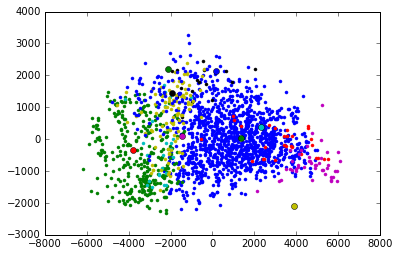

In [225]:
for cluster in range(n_clusters_):    
    ds = data.get_values()[np.where(labels == cluster)]    
    plt.plot(ds[:,0], ds[:,1], '.')    
    lines = plt.plot(cluster_centers[cluster, 0], cluster_centers[cluster, 1], 'o')

Though I'm not sure how to tweak the hyper-parameters of the bandwidth estimation function, there doesn't seem to be much difference. Minute variations to the bandwidth result in large cluster differences. Perhaps the data isn't very suitable for a contrived clustering technique like Mean-Shift. Therefore let us attempt something more naive and simplistic like K-Means

#### K-Means clustering - mds

In [226]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data.get_values())
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids))
print data.shape

Estimated number of clusters: 2
(1823, 20)


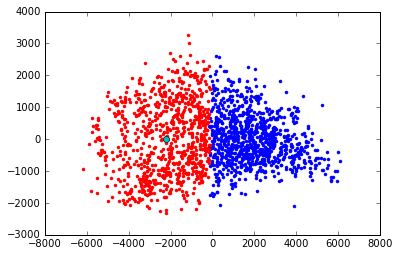

In [227]:
for label in [0, 1]:
    ds = data.get_values()[np.where(labels == label)]    
    plt.plot(ds[:,0], ds[:,1], '.')    
    lines = plt.plot(centroids[i,0], centroids[i,1], 'o')

As is evident from the above 2 experiments, no clear clustering is apparent.But there is some significant overlap and there 2 clear groups

### Classification Experiments

Let's experiment with a bunch of classifiers

In [228]:
ADHD_mds = pd.DataFrame(ADHD_mds)
BP_mds = pd.DataFrame(BP_mds)

In [229]:
BP_mds['ADHD-Bipolar'] = 0
ADHD_mds['ADHD-Bipolar'] = 1

data = pd.concat([ADHD_mds, BP_mds])
class_labels = data['ADHD-Bipolar']
data = data.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
print data.shape
data = data.get_values()

(1823, 20)


In [230]:
# Leave one Out cross validation
def leave_one_out(classifier, values, labels):
    leave_one_out_validator = LeaveOneOut(len(values))
    classifier_metrics = cross_validation.cross_val_score(classifier, values, labels, cv=leave_one_out_validator)
    accuracy = classifier_metrics.mean()
    deviation = classifier_metrics.std()
    return accuracy, deviation

In [231]:
p_val = 100
knn = KNeighborsClassifier(n_neighbors = 5)
svc = SVC(gamma = 2, C = 1)
rf = RandomForestClassifier(n_estimators = 22) 
dt = DecisionTreeClassifier(max_depth = 22) 
qda = QDA()
gnb = GaussianNB()
classifier_accuracy_list = []
classifiers = [(knn, "KNN"), (svc, "SVM"), (rf, "Random Forest"), (dt, "Decision Tree"),
               (qda, "QDA"), (gnb, "Gaussian NB")]
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data, class_labels)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

KNN accuracy is 0.7071 (+/- 0.455)
SVM accuracy is 0.7586 (+/- 0.428)
Random Forest accuracy is 0.7301 (+/- 0.444)
Decision Tree accuracy is 0.6643 (+/- 0.472)
QDA accuracy is 0.6961 (+/- 0.460)
Gaussian NB accuracy is 0.7345 (+/- 0.442)


given the number of people who have ADHD and Bipolar disorder the chance line would be at around 0.6. The classifiers fall between 0.7 and 0.75 which makes them just barely better than chance. This is still an improvement over last time.

### Questions and Answers

Q1) *Did you attempt any further data cleaning?*<br/>
A1) Yes, we threw out the technician assesment of RCBF and the survey responses all together. The reason for this patients have already been systematically clinically diagnosed. Survey responses and technician assesments are subjective. Sometime the respondent didn't even respond to the surveys. This helped us salvage around 300 record<br/>

Q2) through Q3) Did you attempt any manifold dimensionality reduction techniques?<br/>
A2 through A3) Yes<br/>
I found that ISOMAP and MDS do not offer drastically different dimensionaity reductions.<br/>

Q4) Given the new dimensionality reduction was any clustering apparent?<br/>
A4) No, the groups are more spatially distributed than before, but with not much separation<br/>

Q4) through Q)9 *Did you attempt a cross validated train test with a classifier? what were the results?*<br/>
A4) through A)9<br/>
**KNN accuracy is 0.7071 (+/- 0.455)<br/>
SVM accuracy is 0.7586 (+/- 0.428)<br/>
Random Forest accuracy is 0.7301 (+/- 0.444)<br/>
Decision Tree accuracy is 0.6643 (+/- 0.472)<br/>
QDA accuracy is 0.6961 (+/- 0.460)<br/>
Gaussian NB accuracy is 0.7345 (+/- 0.442)<br/>**